In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/548/cd3022/code/python/scripts')
import utils

In [2]:
# # Only look at one season at a time,
# # notebook crashes if too many seasons opened at once
# season = 'Winter'

# # "definition" can mean (mean of daily irradiance is baseline) or max (max of daily irradiance)
# # "threshold" is the proportion of mean/max that distinguishes drought and non-drought days

# definition = 'mean'
# threshold = 0.5

In [3]:
season = sys.argv[1]
definition = sys.argv[2]
threshold = float(sys.argv[3])

In [4]:
# Read data into pd DFs, based on above season


# this is copied from notebook 999. should store in a config.py file and import instead
seasons = [
    # ('1-4-2019', '31-5-2019'), # Autumn 2019, incomplete season
    ('1-6-2019', '31-8-2019'), # Winter 2019
    ('1-9-2019', '30-11-2019'), # Spring 2019
    ('1-12-2019', '29-2-2020'), # Summer 2019/2020
    ('1-3-2020', '31-5-2020'), # Autumn 2020
    ('1-6-2020', '31-8-2020'), # Winter 2020
    ('1-9-2020', '30-11-2020'), # Spring 2020
    ('1-12-2020', '28-2-2021'), # Summer 2020/2021
    ('1-3-2021', '31-5-2021'), # Autumn 2021
    ('1-6-2021', '31-8-2021'), # Winter 2021
    ('1-9-2021', '30-11-2021'), # Spring 2021
    ('1-12-2021', '28-2-2022'), # Summer 2021/2022
    ('1-3-2022', '31-5-2022'), # Autumn 2022
    ('1-6-2022', '31-8-2022'), # Winter 2022
    ('1-9-2022', '30-11-2022'), # Spring 2022
    ('1-12-2022', '28-2-2023'), # Summer 2022/2023
    ('1-3-2023', '31-5-2023'), # Autumn 2023
    ('1-6-2023', '31-8-2023'), # Winter 2023
    ('1-9-2023', '30-11-2023'), # Spring 2023
    ('1-12-2023', '29-2-2024'), # Summer 2023/2024
]

dir_path = '/g/data/er8/users/cd3022/solar_drought/seasonal_daily_means/'

# Record seasonal data based on end month
season_identifier = {
    'Summer':'2', # Feb
    'Autumn':'5', # May
    'Winter':'8', # Aug
    'Spring':'1' # Nov
}


data=[]
num_seasons = 0
for start, end in seasons:
    
    data_file = start+'_'+end+'.pkl'
    print(data_file)
    
    if end[3] == season_identifier[season]:
        df = pd.read_pickle(dir_path + data_file)
        data.append(df)
        print(f'Adding {data_file} to {season}')
        num_seasons += 1

DF = pd.concat(data)

1-6-2019_31-8-2019.pkl
Adding 1-6-2019_31-8-2019.pkl to Winter
1-9-2019_30-11-2019.pkl
1-12-2019_29-2-2020.pkl
1-3-2020_31-5-2020.pkl
1-6-2020_31-8-2020.pkl
Adding 1-6-2020_31-8-2020.pkl to Winter
1-9-2020_30-11-2020.pkl
1-12-2020_28-2-2021.pkl
1-3-2021_31-5-2021.pkl
1-6-2021_31-8-2021.pkl
Adding 1-6-2021_31-8-2021.pkl to Winter
1-9-2021_30-11-2021.pkl
1-12-2021_28-2-2022.pkl
1-3-2022_31-5-2022.pkl
1-6-2022_31-8-2022.pkl
Adding 1-6-2022_31-8-2022.pkl to Winter
1-9-2022_30-11-2022.pkl
1-12-2022_28-2-2023.pkl
1-3-2023_31-5-2023.pkl
1-6-2023_31-8-2023.pkl
Adding 1-6-2023_31-8-2023.pkl to Winter
1-9-2023_30-11-2023.pkl
1-12-2023_29-2-2024.pkl


In [5]:
# Regions to analyse, using sh ABS shapefile

regions = [
    '1GSYD',
    '2GMEL',
    '3GBRI',
    '4GADE',
    '5GPER',
    '6GHOB',
    '7GDAR',
    '8ACTE'
]

# https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files
shape_file = '/home/548/cd3022/data/boundary_files/GCCSA/GCCSA_2021_AUST_GDA2020.shp'

region_masks = utils.get_region_mask(
    shape_file=shape_file,
    regions=regions
)

region_means = [
    np.ma.masked_array(np.repeat(dm[None, ...], len(region_masks), axis=0), mask=~region_masks).mean(axis=(1, 2))
    for dm in DF['daily_mean']
]
print('Regional data produced with shape file')

Regional data produced with shape file


In [6]:
# Using the loaded daily mean irradiance data, find drought days using specified definition

# All aus pixels
national_droughts = utils.find_droughts(
    data = DF['daily_mean'].values,
    definition = definition,
    threshold = threshold
)
national_droughts.index = DF.index

print('National drought DF built')


# Mean values over capital city regions
region_droughts = utils.find_droughts(
    data = region_means,
    definition = definition,
    threshold = threshold
)
region_droughts.index = DF.index

print('Regional drought DF built')

# Total number of drought days in the season, used for plots
num_drought_days = np.ma.sum(np.ma.stack(national_droughts['is_drought_day'].values), axis=0)
region_drought_days = np.ma.sum(np.ma.stack(region_droughts['is_drought_day'].values), axis=0)

National drought DF built
Regional drought DF built


In [7]:
# Collect all coincident drought data and save, so it can be combined with other seasons for uninterrupted timeseries

coincident_DF = national_droughts[['coincident_droughts']]
coincident_DF = coincident_DF.rename(columns={'coincident_droughts':'national'})

# 2D array of masks for capital cities
flat_region_masks = np.any(region_masks, axis=0) 
coincident_droughts_regional = [np.sum(np.ma.masked_array(droughts, mask=~flat_region_masks)) for droughts in national_droughts['is_drought_day'].values]

coincident_DF['regional'] = coincident_droughts_regional
coincident_DF['regional_mean'] = region_droughts['coincident_droughts'].values

coincident_DF.to_pickle(f'/g/data/er8/users/cd3022/solar_drought/coincident_time_series/{season}_{definition}_{threshold}.pkl')

print('coincident DF saved')

coincident DF saved


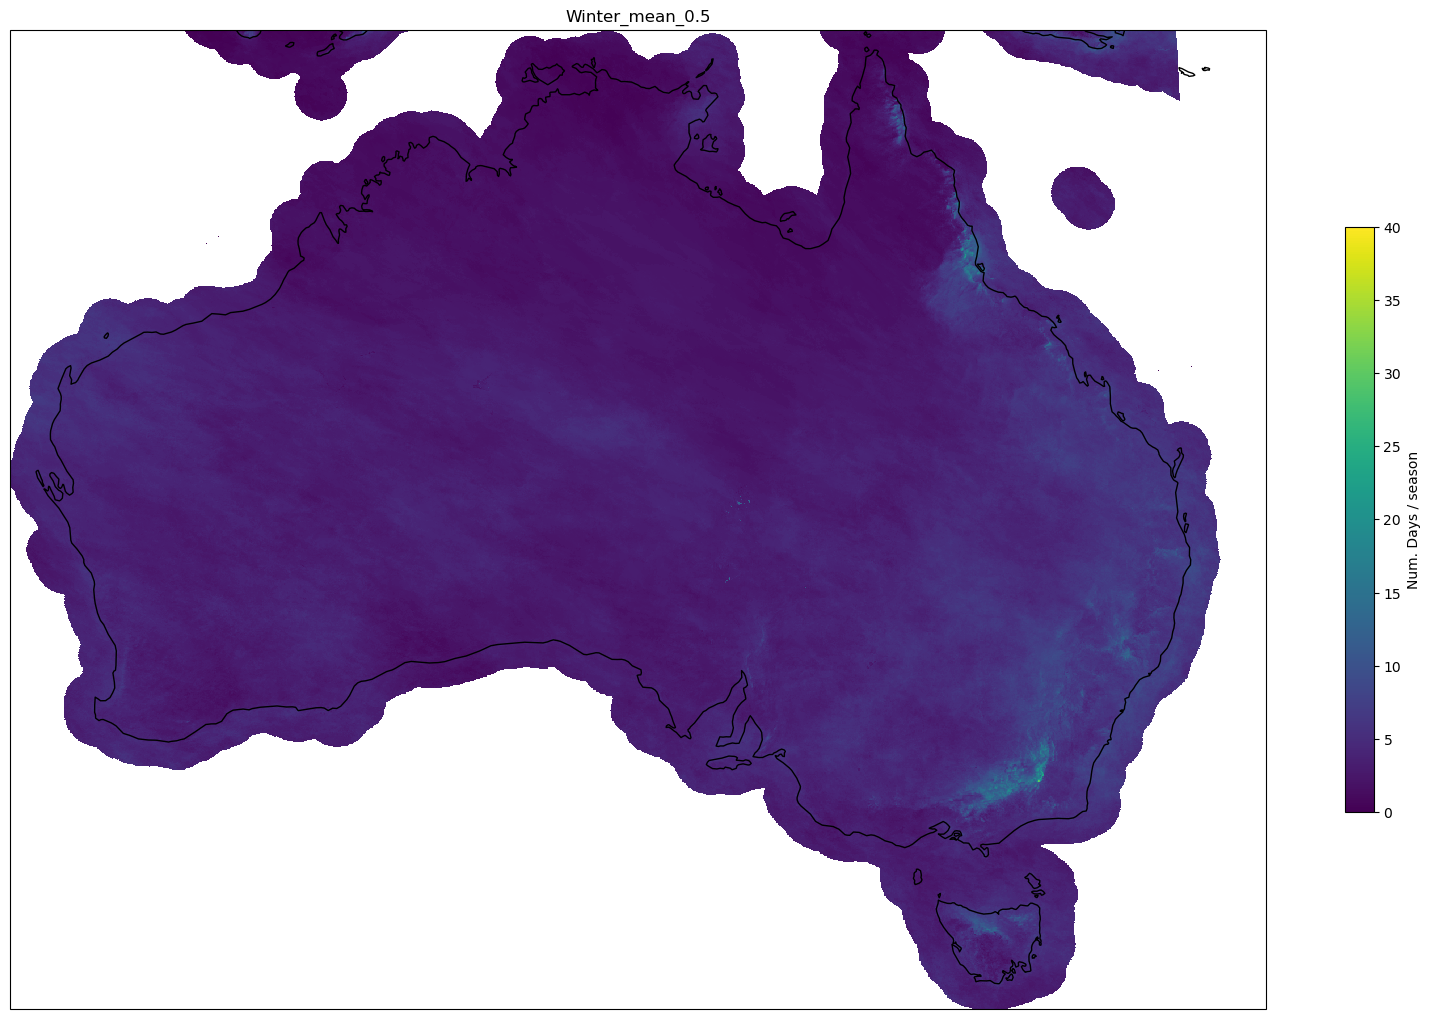

In [8]:
fig_name = f'{season}_{definition}_{threshold}'
utils.plot_area(
    data=num_drought_days / num_seasons,
    fig_name=fig_name,
    vmax=20
)

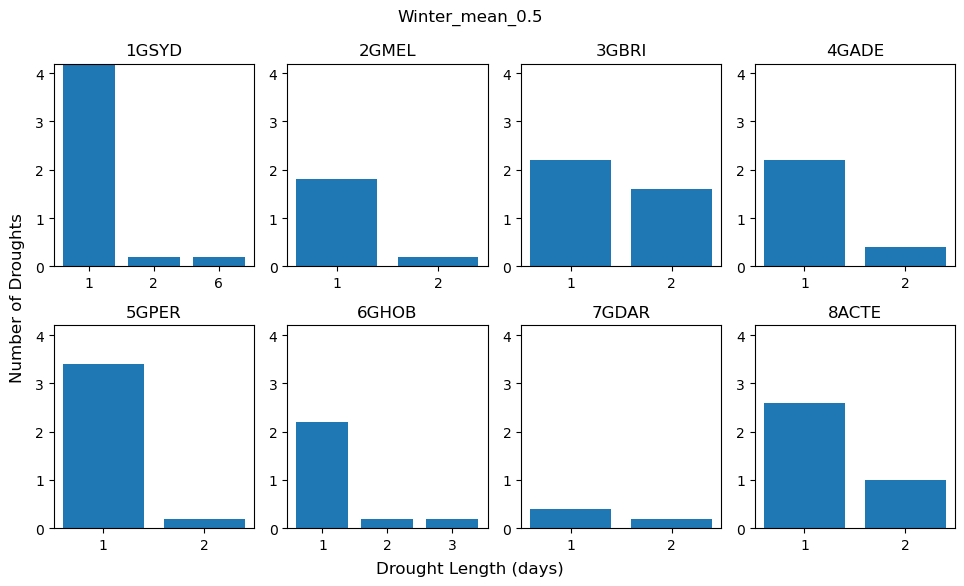

In [9]:
regional_drought_lengths = utils.regional_drought_lengths(df=region_droughts, regions=regions)

fig, axes = plt.subplots(2, 4, figsize=(10, 6))  # 4 rows and 2 columns of subplots
axes = axes.ravel()
max_num = 1

# Plot data for each region
for idx, (region, data) in enumerate(regional_drought_lengths.items()):
    ax = axes[idx]

    if not data:
        sorted_keys, sorted_values = (0, 0)
    else:
        # get the drought lengths in order for the plot
        sorted_data = sorted(data.items(), key=lambda x: int(x[0]))
        sorted_keys, sorted_values = zip(*sorted_data)


    if np.max(sorted_values) > max_num:
        max_num = np.max(sorted_values)
    
    ax.bar(sorted_keys, np.array(sorted_values) / num_seasons)
    ax.set_title(region)

# set equal y axis
for i in range(8):
    ax = axes[i]
    ax.set_ylim(0,9)

# Add global x and y labels
fig.text(0.5, 0.04, 'Drought Length (days)', ha='center', fontsize=10)  # x-label
fig.text(0.04, 0.5, 'Number of Droughts / season', va='center', rotation='vertical', fontsize=10)  # y-label

plt.suptitle(f'{season}_{definition}_{threshold}')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig(f'/home/548/cd3022/figs/regional_histograms/{season}_{definition}_{threshold}.png')
plt.show()

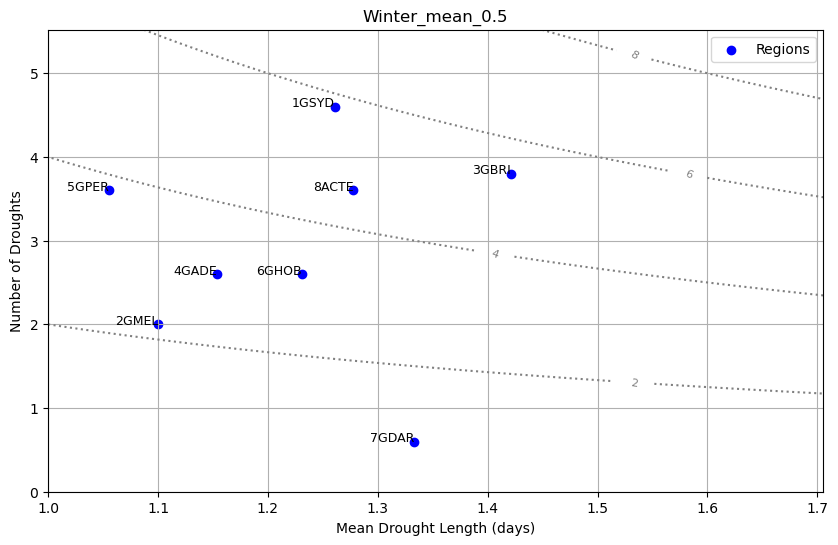

In [11]:
# Produce Figure 4 from Raynaud et al. (2018)
# Make tuple (x,y) where x is the mean drought length in that region,
# and y is the total number of drought days experienced.
raynaud_plot_data = {}
for i, region in enumerate(regional_drought_lengths):
    droughts = regional_drought_lengths[region]
    num_droughts = sum(droughts.values())
    if num_droughts == 0:
        raynaud_plot_data[region] = (0, 0)
    else:
        raynaud_plot_data[region] = (region_drought_days[i] / num_droughts, num_droughts / num_seasons)

# Extract x and y values for plotting
x_values = [coords[0] for coords in raynaud_plot_data.values()]
y_values = [coords[1] for coords in raynaud_plot_data.values()]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, color="blue", label="Regions")

# Annotate points with region names
for region, (x, y) in raynaud_plot_data.items():
    plt.text(x, y, region, fontsize=9, ha="right")

# Add contours of constant total drought days (x * y)
x = np.linspace(0, max(x_values) * 1.2, 100)
y = np.linspace(0, max(y_values) * 1.2, 100)
X, Y = np.meshgrid(x, y)
Z = X * Y  # Total drought days

# Contour levels
contour_levels = [x for x in range(2, 16)]
contours = plt.contour(X, Y, Z, levels=contour_levels, colors='gray', linestyles='dotted')
plt.clabel(contours, inline=True, fontsize=8, fmt='%d')  # Label contours

# Final plot customizations
plt.xlabel("Mean Drought Length (days)")
plt.ylabel("Number of Droughts / season")
plt.title(f'{season}_{definition}_{threshold}')
plt.grid(True)
plt.legend()
plt.xlim(1,2)
plt.ylim(0,12)
plt.savefig(f'/home/548/cd3022/figs/Raynaud_plots/{season}_{definition}_{threshold}.png')
plt.show()

In [1]:
if __name__ == '__main__':
    
    NOTEBOOK_PATH="/home/548/cd3022/code/python/notebooks/007_read-batches.ipynb"
    SCRIPT_PATH="/home/548/cd3022/code/python/scripts/007_read-batches"
    
    !jupyter nbconvert --to script {NOTEBOOK_PATH} --output {SCRIPT_PATH}

[NbConvertApp] Converting notebook /home/548/cd3022/code/python/notebooks/007_read-batches.ipynb to script
[NbConvertApp] Writing 8169 bytes to /home/548/cd3022/code/python/scripts/007_read-batches.py


In [13]:
print('Notebook finished')

Notebook finished
